In [2]:
%load_ext autoreload
%autoreload 2

# Data

In [3]:
import numpy as np
import tensorflow as tf

from time import time
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
UNK_token = 0
SOS_token = 1
EOS_token = 2

In [5]:
with open('./nmt_data/vocab.en', 'r') as f, open('./nmt_data/vocab.vi', 'r') as g:
    src_vocab = [x[:-1] for x in f.readlines()]
    tgt_vocab = [x[:-1] for x in g.readlines()]
    
def list_to_dict(vocab_list):
    ret = {}
    for i in range(len(vocab_list)):
        ret[i] = vocab_list[i]
    
    return ret

src_vocab, tgt_vocab = list_to_dict(src_vocab), list_to_dict(tgt_vocab)
src_vocab_inv, tgt_vocab_inv = {v: k for k, v in src_vocab.items()}, {v: k for k, v in tgt_vocab.items()}


def word2idx(vocab_inv, word):
    try:
        ret = vocab_inv[word]
    except:
        ret = UNK_token
    return ret

def idx2word(vocab, idx):
    return vocab[idx]

word2idx(src_vocab_inv, 'armpits'), idx2word(src_vocab, 17156)

In [6]:
with open('./nmt_data/train.en', 'r') as f:
    ss_L = [[word2idx(src_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]

print(ss_L[0], [idx2word(src_vocab, x) for x in ss_L[0]])

In [7]:
sources = ss_L
sources = np.array(sources)

with open('./nmt_data/train.vi', 'r') as f:
    targets = [[word2idx(tgt_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]

targets = np.array(targets)

targets[0], [idx2word(tgt_vocab, x) for x in targets[0]]

# Batch

In [8]:
batch_size = 128
max_time = 50
time_major = True

In [9]:
class Dummy(object):
    pass


def batch_iter(batch_size, sources, targets, ending=False):
    """
        Generates a batch iterator for the dataset.
    """

    data_size = len(sources)

    rand_inds = np.random.permutation(np.arange(data_size))

    num_batches = int(data_size / batch_size)

    if data_size % batch_size > 0:
        num_batches = int(data_size / batch_size) + 1

    batch_num = 0
    end_flag = False
    while True:
        start_index = batch_num * batch_size
        end_index = (batch_num + 1) * batch_size
        
        if end_index > data_size:
            if ending:
                end_flag = True
            else: 
                print('rebatching...')
                batch_num = 0
                rand_inds = np.random.permutation(rand_inds)
                start_index = 0
                end_index = batch_size
        
        
        srcs = sources[rand_inds[start_index:end_index]]
        tgts = targets[rand_inds[start_index:end_index]]
        source_sequence_lengths = np.array([np.min([len(x)+1, max_time]) for x in srcs])
        target_sequence_lengths = np.array([np.min([len(x)+1, max_time]) for x in tgts])
        
        srcs = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in srcs])
        tgts = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in tgts])
        
        srcs = srcs.T
        tgts = tgts.T
        
        params = Dummy()
        params.source_sequence_lengths = source_sequence_lengths
        params.target_sequence_lengths = target_sequence_lengths
        params.sources = srcs
        params.targets = tgts
        
        yield params
        
        if end_flag:
            return
        
        batch_num += 1

In [10]:
batch = batch_iter(batch_size, sources, targets)

params = next(batch)
print(params.sources[:,0])
print(params.source_sequence_lengths[0])

# Model

In [11]:
from tensorflow.python.layers import core as layers_core
from tqdm import tqdm

In [12]:
# # Building the models

# ## The Embedding

# In[9]:

src_vocab_size = len(src_vocab)
tgt_vocab_size = len(tgt_vocab)
embedding_size = 512
num_units = embedding_size

In [13]:
def initialization():
    model = Dummy()
    model.encoder_inputs = tf.placeholder('int32', [max_time, None], name='encoder_inputs')
    model.targets = tf.placeholder('int32', [max_time, None], name='target')
    model.decoder_inputs = tf.concat([tf.fill([1, tf.shape(model.targets)[1]], SOS_token), model.targets[:-1,:]], 0)
    
    model.source_sequence_lengths = tf.placeholder('int32', [None], name='source_sequence_lengths')
    model.target_sequence_lengths = tf.placeholder('int32', [None], name='target_sequence_lengths')
    
    model.dropout = tf.placeholder('float32', [], name='dropout')
    model.learning_rate = tf.placeholder('float32', [], name='learning_rate')
    model.max_gradient_norm = tf.placeholder('float32', [], name='max_gradient_norm') # often set to a value like 5 or 1

    
    return model

model = initialization()

In [14]:
def embedding(model):
    with tf.variable_scope("embedding", dtype='float32') as scope:
        # Embedding
        embedding_encoder = tf.get_variable("embedding_encoder", [src_vocab_size, embedding_size])
        embedding_decoder = tf.get_variable("embedding_decoder", [tgt_vocab_size, embedding_size])
        # Look up embedding:
        #   encoder_inputs: [max_time, batch_size]
        #   encoder_emp_inp: [max_time, batch_size, embedding_size]
        encoder_emb_inp = tf.nn.embedding_lookup(embedding_encoder, model.encoder_inputs)
        decoder_emb_inp = tf.nn.embedding_lookup(embedding_decoder, model.decoder_inputs)
        
        model.embedding_encoder = embedding_encoder
        model.embedding_decoder = embedding_decoder
        model.encoder_emb_inp = encoder_emb_inp
        model.decoder_emb_inp = decoder_emb_inp
        
    return model

model = embedding(model)

In [15]:
# ## The Encoder
def encoder(model):
    with tf.variable_scope("encoder", dtype='float32') as scope:
        # Build RNN cell
        # Construct forward and backward cells
        forward_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
        forward_cell = tf.contrib.rnn.DropoutWrapper(cell=forward_cell, input_keep_prob=(1.0 - model.dropout))
        backward_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
        backward_cell = tf.contrib.rnn.DropoutWrapper(cell=backward_cell, input_keep_prob=(1.0 - model.dropout))

        bi_outputs, bi_encoder_state = tf.nn.bidirectional_dynamic_rnn(
            forward_cell, backward_cell, model.encoder_emb_inp, dtype='float32',
            sequence_length=model.source_sequence_lengths, time_major=True)
        bi_encoder_outputs = tf.concat(bi_outputs, -1)
        
        encoder_outputs = bi_encoder_outputs
        encoder_state = bi_encoder_state
        """
        # Stacking encoders
        encoder_cell = tf.contrib.rnn.BasicLSTMCell(num_units)

        # Run Dynamic RNN
        #   encoder_outpus: [max_time, batch_size, num_units]
        #   encoder_state: [batch_size, num_units]
        encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
            encoder_cell, bi_encoder_outputs, dtype='float32',
            sequence_length=model.source_sequence_lengths, time_major=True)
        """        
        model.encoder_outputs = encoder_outputs
        model.encoder_state = encoder_state
        
    return model

model = encoder(model)

In [16]:
# ## Decoder
def decoder(model):
    with tf.variable_scope("decoder", dtype='float32') as scope:
        """ Attention Mechanisms """
        # attention_states: [batch_size, max_time, num_units]
        attention_states = tf.transpose(model.encoder_outputs, [1, 0, 2])

        # Create an attention mechanism
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(
            num_units, attention_states, scale=True,
            memory_sequence_length=model.source_sequence_lengths)

        # Build RNN cell
        cell_list = []
        for i in range(2):
            cell = tf.contrib.rnn.BasicLSTMCell(num_units)
            cell = tf.contrib.rnn.DropoutWrapper(cell=cell, input_keep_prob=(1.0 - model.dropout))
            cell_list.append(cell)
        
        decoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)

        decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
            decoder_cell, attention_mechanism,
            attention_layer_size=num_units, name="attention")

        decoder_initial_state = decoder_cell.zero_state(tf.shape(model.decoder_emb_inp)[1], 'float32').clone(cell_state=model.encoder_state)
        """"""
        # Helper
        helper = tf.contrib.seq2seq.TrainingHelper(
            model.decoder_emb_inp, model.target_sequence_lengths, time_major=True)
        # Decoder
        decoder = tf.contrib.seq2seq.BasicDecoder(
            decoder_cell, helper, decoder_initial_state)
        # Dynamic decoding
        outputs, final_context_state, _ = tf.contrib.seq2seq.dynamic_decode(
            decoder,
            output_time_major=True,
            swap_memory=True,
            scope=scope)

        #projection
        output_layer = layers_core.Dense(tgt_vocab_size, use_bias=False, name="output_projection")
        logits = output_layer(outputs.rnn_output)
        
    model.logits = logits
    model.decoder_cell = decoder_cell
    model.decoder_initial_state = decoder_initial_state
    model.output_layer = output_layer
    model.final_context_state = final_context_state
    
    return model

model = decoder(model)

In [17]:
# ## Loss & Gradient computation & optimization

def optimizer(model):
    curr_max_time = tf.shape(model.logits)[0]
    crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=model.targets[:curr_max_time,:], logits=model.logits)
    target_weights = tf.sequence_mask(model.target_sequence_lengths, curr_max_time, dtype=model.logits.dtype)

    # When time_major is True
    target_weights = tf.transpose(target_weights)

    loss = tf.reduce_sum(crossent * target_weights) / tf.to_float(tf.shape(model.decoder_emb_inp)[1])

    # Calculate and clip gradients
    parameters = tf.trainable_variables()
    gradients = tf.gradients(loss, parameters)
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, model.max_gradient_norm)

    # Optimization
    optimizer = tf.train.GradientDescentOptimizer(model.learning_rate)
    update_step = optimizer.apply_gradients(zip(clipped_gradients, parameters))
    
    model.loss = loss
    model.update_step = update_step
    
    return model

model = optimizer(model)

In [18]:
def create_model():
    model = initialization()
    model = embedding(model)
    model = encoder(model)
    model = decoder(model)
    
    return model

#saver = tf.train.Saver()
#saver.restore(sess, './log/model.ckpt')

In [19]:
model = create_model()
model = optimizer(model)

In [20]:
# ## Running training

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

with sess:
    new_saver = tf.train.import_meta_graph('./log/benchmark_512_final.ckpt.meta')
    new_saver.restore(sess, './log/benchmark_512_final.ckpt')

saver = tf.train.Saver()
saver.restore(sess, './log/benchmark_512_final.ckpt')

In [21]:
ls = []

In [22]:
t_str = time()
for i in range(8000):
    
    params = next(batch)
    feed_dict={model.learning_rate: 1.,
               model.dropout: .2,
               model.max_gradient_norm: 5,
               model.source_sequence_lengths: params.source_sequence_lengths,
               model.target_sequence_lengths: params.target_sequence_lengths,
               model.encoder_inputs: params.sources,
               model.targets: params.targets}


    _, l_val = sess.run([model.update_step, model.loss], feed_dict=feed_dict)
    ls.append(l_val)
    print(i, end='\r')
print(time() - t_str)

rebatching...
rebatching...
rebatching...
rebatching...
rebatching...
rebatching...
rebatching...
5911.572916507721


In [23]:
t_str = time()
for i in range(1000):
    
    params = next(batch)
    feed_dict={model.learning_rate: .5,
               model.dropout: .2,
               model.max_gradient_norm: 5,
               model.source_sequence_lengths: params.source_sequence_lengths,
               model.target_sequence_lengths: params.target_sequence_lengths,
               model.encoder_inputs: params.sources,
               model.targets: params.targets}


    _, l_val = sess.run([model.update_step, model.loss], feed_dict=feed_dict)
    ls.append(l_val)
    print(i, end='\r')
print(time() - t_str)

rebatching...
738.2864482402802


In [24]:
t_str = time()
for i in range(1000):
    
    params = next(batch)
    feed_dict={model.learning_rate: .25,
               model.dropout: .2,
               model.max_gradient_norm: 5,
               model.source_sequence_lengths: params.source_sequence_lengths,
               model.target_sequence_lengths: params.target_sequence_lengths,
               model.encoder_inputs: params.sources,
               model.targets: params.targets}


    _, l_val = sess.run([model.update_step, model.loss], feed_dict=feed_dict)
    ls.append(l_val)
    print(i, end='\r')
print(time() - t_str)

rebatching...
737.8757576942444


In [25]:
t_str = time()
for i in range(1000):
    
    params = next(batch)
    feed_dict={model.learning_rate: .125,
               model.dropout: .2,
               model.max_gradient_norm: 5,
               model.source_sequence_lengths: params.source_sequence_lengths,
               model.target_sequence_lengths: params.target_sequence_lengths,
               model.encoder_inputs: params.sources,
               model.targets: params.targets}


    _, l_val = sess.run([model.update_step, model.loss], feed_dict=feed_dict)
    ls.append(l_val)
    print(i, end='\r')
print(time() - t_str)

rebatching...
738.5889222621918


In [26]:
t_str = time()
for i in range(1000):
    
    params = next(batch)
    feed_dict={model.learning_rate: .0625,
               model.dropout: .2,
               model.max_gradient_norm: 5,
               model.source_sequence_lengths: params.source_sequence_lengths,
               model.target_sequence_lengths: params.target_sequence_lengths,
               model.encoder_inputs: params.sources,
               model.targets: params.targets}


    _, l_val = sess.run([model.update_step, model.loss], feed_dict=feed_dict)
    ls.append(l_val)
    print(i, end='\r')
print(time() - t_str)

rebatching...
739.0206029415131


In [1]:
ls_file = open('./benchmark_512_real_ls.txt', 'r')
ls = [float(x) for x in ls_file.readlines()]

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [40]:
ls[7000:8000]

[53.143414,
 49.72031,
 49.299969,
 50.240036,
 46.464455,
 52.490257,
 48.094452,
 52.690983,
 46.974625,
 58.19912,
 52.222328,
 50.401428,
 55.259796,
 49.379219,
 51.854889,
 52.880768,
 52.471916,
 48.458328,
 55.462204,
 51.538651,
 55.067039,
 51.533176,
 49.016018,
 54.387123,
 56.270542,
 52.420204,
 56.779781,
 52.289497,
 51.178707,
 50.111916,
 51.275314,
 55.276569,
 53.139465,
 52.177704,
 56.202019,
 52.70628,
 53.697899,
 51.020424,
 55.877922,
 51.714622,
 52.650631,
 55.46146,
 53.335461,
 49.685627,
 48.444736,
 48.828743,
 53.834534,
 51.649612,
 54.52853,
 59.532326,
 53.562389,
 55.67326,
 49.245934,
 49.074654,
 56.353828,
 51.14838,
 48.951698,
 57.396957,
 49.432053,
 49.639004,
 49.465839,
 54.641548,
 50.989071,
 44.644493,
 49.81469,
 51.04425,
 46.662266,
 48.949688,
 45.700272,
 53.464577,
 56.803242,
 50.418732,
 50.775135,
 48.489571,
 47.850334,
 48.473003,
 55.696526,
 56.051182,
 52.510094,
 47.807404,
 53.435261,
 54.879814,
 56.945614,
 53.558258,
 

(30, 220)

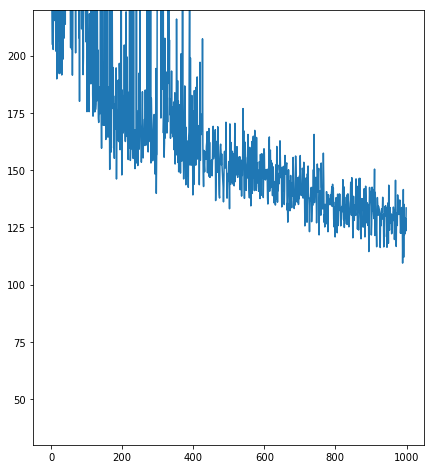

In [3]:
view_str_idx = 0
interval = 1000
plt.figure(figsize=(7,8))
plt.plot(np.arange(view_str_idx, np.min([len(ls), view_str_idx+interval])), ls[view_str_idx:view_str_idx+interval])
plt.ylim(30,220)

In [40]:
batch_val = batch_iter(128, sources_val, targets_val, ending=True)
tmp_vals = []
for params in batch_val:
    feed_dict_test={model.dropout: 0.,
                    model.source_sequence_lengths: params.source_sequence_lengths,
                    model.target_sequence_lengths: params.target_sequence_lengths,
                    model.encoder_inputs: params.sources,
                    model.targets: params.targets}
    tmp_vals.append(sess.run(model.loss_eval, feed_dict_test))
np.mean(tmp_vals)

53.35083

saver = tf.train.Saver()
saver.save(sess, './log/benchmark_512_real.ckpt')

ls_file = open('./benchmark_512_real_ls.txt', 'w')

for item in ls:
    ls_file.write("%f\n" % item)

# Evaluation

In [27]:
from bleu import _bleu_online

In [28]:
def arr2stn(vocab, sentences):
    def foo_iter(stn):
        try:
            end_idx = stn.index(EOS_token)
        except:
            end_idx = len(stn)
        return ' '.join([idx2word(vocab, word) for word in stn[:end_idx]])
    
    sentences = sentences.tolist()
    ret = []
    
    if len(sentences)==0:
        stn = sentences
        ret.append(foo_iter(stn))
        
    else:
        for stn in sentences:
            ret.append(foo_iter(stn))
    return ret

In [29]:
# # Evaluating the network
def evaluation(model):
    # In[34]:

    model.maximum_iterations = tf.round(tf.reduce_max(model.source_sequence_lengths) * 2)


    # In[35]:

    with tf.variable_scope('decoder', reuse=True) as scope:
    # Dynamic decoding
        # Helper
        helper_eval = tf.contrib.seq2seq.GreedyEmbeddingHelper(
            model.embedding_decoder, tf.fill([tf.shape(model.decoder_emb_inp)[1]], SOS_token),
            EOS_token)
        # Decoder
        decoder_eval = tf.contrib.seq2seq.BasicDecoder(
            model.decoder_cell, helper_eval, model.decoder_initial_state,
            output_layer=model.output_layer)

        outputs_eval, final_context_state_eval, _ = tf.contrib.seq2seq.dynamic_decode(
            decoder_eval, maximum_iterations=model.maximum_iterations,
            swap_memory=True, scope=scope)

        model.logits_eval = outputs_eval.rnn_output
        
    curr_max_time = tf.shape(model.logits)[0]
    crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=model.targets[:curr_max_time,:], logits=model.logits)
    target_weights = tf.sequence_mask(model.target_sequence_lengths, curr_max_time, dtype=model.logits.dtype)

    # When time_major is True
    target_weights = tf.transpose(target_weights)

    loss = tf.reduce_sum(crossent * target_weights) / tf.to_float(tf.shape(model.decoder_emb_inp)[1])
    
    model.loss_eval = loss
    return model

In [30]:
model_eval = evaluation(model)

In [31]:
with open('./nmt_data/tst2012.en', 'r') as f:
    sources_val = [[word2idx(src_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]
sources_val = np.array(sources_val)

with open('./nmt_data/tst2012.vi', 'r') as f:
    targets_val = [[word2idx(tgt_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]
targets_val = np.array(targets_val)

In [32]:
batch_val = batch_iter(128, sources_val, targets_val, ending=True)
truths = []
preds = []
for params in batch_val:
    feed_dict_test={model.dropout: 0.,
                    model.source_sequence_lengths: params.source_sequence_lengths,
                    model.target_sequence_lengths: params.target_sequence_lengths,
                    model.encoder_inputs: params.sources,
                    model.targets: params.targets}
    
    truths.extend(arr2stn(tgt_vocab, params.targets.T))
    preds.extend(arr2stn(tgt_vocab, np.argmax(sess.run(model.logits_eval, feed_dict_test),2)))
    
_bleu_online([truths], preds)

25.105043353616317

In [33]:
with open('./nmt_data/tst2013.en', 'r') as f:
    sources_tst = [[word2idx(src_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]
sources_tst = np.array(sources_tst)

with open('./nmt_data/tst2013.vi', 'r') as f:
    targets_tst = [[word2idx(tgt_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]
targets_tst = np.array(targets_tst)

In [34]:
batch_val = batch_iter(128, sources_tst, targets_tst, ending=True)
truths = []
preds = []
for params in batch_val:
    feed_dict_test={model.dropout: 0.,
                    model.source_sequence_lengths: params.source_sequence_lengths,
                    model.target_sequence_lengths: params.target_sequence_lengths,
                    model.encoder_inputs: params.sources,
                    model.targets: params.targets}
    
    truths.extend(arr2stn(tgt_vocab, params.targets.T))
    preds.extend(arr2stn(tgt_vocab, np.argmax(sess.run(model.logits_eval, feed_dict_test),2)))
    
_bleu_online([truths], preds)

27.340469062282168

# Train with Evaluation